# Data Filtering and Binning

This notebook lets you filter and bin tabular data from ISS and INO images.

For best results, run cells from the top down.

In [1]:
# Run this cell to import required python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt

def filter_df(df, **filterDict):
    """
    this function will filter a dataframe according to the parameters given by the filterDict **kwarg

    :param df: dataframe to filter
    :param **filterDict: dictionary, filtering parameters to use

    :return: filtered sub-dataframe
    """
    subdf = df.copy()
    cols = list(subdf.columns)
    for key in filterDict:
        value = filterDict[key]
        if value != None:
            if key in cols:
                op = value[:2]
                if key == 'Well_ID':
                    #check well IDs
                    if op == 'ee':
                        limit = value[2:]
                        subdf = subdf[subdf[key] == limit]
                elif key == 'Acceptor/Donor_ratio':
                    limit = float(value[2:])  #maybe want to add something for conversion errors, but error message may be enough
                    if 'Well_ID' in cols:
                        if op == 'gt':
                            subdf = subdf[subdf['Spectral_Range0_intensity']/subdf['Donor_intensity'] > limit]
                        elif op == 'lt':
                            subdf = subdf[subdf['Spectral_Range0_intensity']/subdf['Donor_intensity'] < limit]
                        elif op == 'ge':
                            subdf = subdf[subdf['Spectral_Range0_intensity']/subdf['Donor_intensity'] >= limit]
                        elif op == 'le':
                            subdf = subdf[subdf['Spectral_Range0_intensity']/subdf['Donor_intensity'] <= limit]
                        elif op == 'ee':
                            subdf = subdf[subdf['Spectral_Range0_intensity']/subdf['Donor_intensity'] == limit]
                    else:
                        if op == 'gt':
                            subdf = subdf[subdf['Acceptor_intensity']/subdf['Donor_intensity'] > limit]
                        elif op == 'lt':
                            subdf = subdf[subdf['Acceptor_intensity']/subdf['Donor_intensity'] < limit]
                        elif op == 'ge':
                            subdf = subdf[subdf['Acceptor_intensity']/subdf['Donor_intensity'] >= limit]
                        elif op == 'le':
                            subdf = subdf[subdf['Acceptor_intensity']/subdf['Donor_intensity'] <= limit]
                        elif op == 'ee':
                            subdf = subdf[subdf['Acceptor_intensity']/subdf['Donor_intensity'] == limit]
                else:
                    limit = float(value[2:])  #maybe want to add something for conversion errors, but error message may be enough
                    if op == 'gt':
                        subdf = subdf[subdf[key] > limit]
                    elif op == 'lt':
                        subdf = subdf[subdf[key] < limit]
                    elif op == 'ge':
                        subdf = subdf[subdf[key] >= limit]
                    elif op == 'le':
                        subdf = subdf[subdf[key] <= limit]
                    elif op == 'ee':
                        subdf = subdf[subdf[key] == limit]
    return subdf

def data_binning(xdata, ydata, auto_bins=True, bin_edges=[]):
    """
    this function will bin the fret efficiency values in order to make a nice binding curve plot
    
    :param ratio: array of data for x axis
    :param FRET: array of data for y axis
    :parm auto_bins: bool. if true, bins are set automatically (with more bins earlier in the dataset). if false, bins are defined by bin_edges.
    :param bin_edges: list of bin edges

    :return: bin sizes, mean y per bin, median y per bin, y std deviation per bin, y std error per bin, bin centers, mean x per bin
    """
    x_array = np.array(xdata)
    y_array = np.array(ydata)
    y_bins = []
    x_bins = []
    x_bin_centers = []
    bin_sizes = []
    i = 0         #i should be bin center.
    lim = np.max(x_array)
    if auto_bins:
        while i <= lim:
            if i < lim/4:
                bin_size=lim*0.015
            elif i < lim/2:
                bin_size= lim*0.05
            else:
                bin_size=lim*0.1
            y_vals = y_array[np.logical_and(x_array >= i-bin_size, x_array < i+bin_size)]
            x_vals = x_array[np.logical_and(x_array >= i-bin_size, x_array < i+bin_size)]
            y_bins.append(y_vals)
            x_bins.append(x_vals)
            x_bin_centers.append(i)
            bin_sizes.append(len(y_vals))
            i += 2*bin_size
    elif bin_edges != []:
        for i in range(len(bin_edges) -1):
            center = (bin_edges[i] + bin_edges[i+1])/2
            y_vals = y_array[np.logical_and(x_array >= bin_edges[i], x_array < bin_edges[i+1])]
            x_vals = x_array[np.logical_and(x_array >= bin_edges[i], x_array < bin_edges[i+1])]
            y_bins.append(y_vals)
            x_bins.append(x_vals)
            bin_sizes.append(len(y_vals))
            x_bin_centers.append(center)
    else:
        print('No bins selected')
        return None
    y_means = np.array([])
    y_medians = np.array([])
    y_std_devs = np.array([])
    y_std_errs = np.array([])
    x_means = np.array([])
    for i, bin in enumerate(y_bins):
        y_means = np.append(y_means, np.mean(bin))
        y_medians = np.append(y_medians, np.median(bin))
        y_std_devs = np.append(y_std_devs, np.std(bin))
        y_std_errs = np.append(y_std_errs, ( np.std(bin) / np.sqrt( len(bin) ) ) )
        x_means = np.append(x_means, np.mean(x_bins[i]))
    return bin_sizes, y_means, y_medians, y_std_devs, y_std_errs, x_bin_centers, x_means

In [2]:
#Run this cell to load csv file:
file = r'my_path' #replace path with full path to csv file surrounded by quotation marks.
df = pd.read_csv(file)

In [3]:
# Run this cell to get a description of the csv file's data
df.describe()

,Unnamed: 0,Slice_ID,ROI_ID,ROI_size,Donor_T0_intensity,Acceptor_T0_intensity,Donor_intensity,Acceptor_intensity,Donor_lifetime,Phasor_G,Phasor_S,FRET_efficiency
count,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,14068.000000,1.406800e+04,14068.000000,14068.000000,14068.000000
mean,7033.500000,37.904180,101.299545,48.948891,449160.734622,81562.601436,529.854492,56.680056,3.679021e-09,0.837557,0.386194,3.183655
std,4061.226128,23.564581,65.037201,28.981576,140620.080465,69837.026924,218.085508,147.382393,1.911142e-10,0.012158,0.015013,5.029322
min,0.000000,0.000000,1.000000,1.000000,3650.333333,521.000000,21.000000,0.000000,1.885912e-09,0.701402,0.223886,-53.670639
25%,3516.750000,17.000000,46.000000,30.000000,359474.666667,20408.000000,368.750479,2.788316,3.678901e-09,0.832255,0.386495,0.983660
50%,7033.500000,36.000000,95.000000,46.000000,477325.333333,61003.333333,517.781250,5.600000,3.724572e-09,0.834803,0.389988,1.984942
75%,10550.250000,59.000000,151.000000,64.000000,522305.333333,117200.666667,670.191219,13.153880,3.762621e-09,0.837805,0.392800,3.186807
max,14067.000000,79.000000,303.000000,230.000000,697898.666667,263729.666667,1499.953125,1133.633333,5.839484e-09,0.951423,0.514351,50.370743


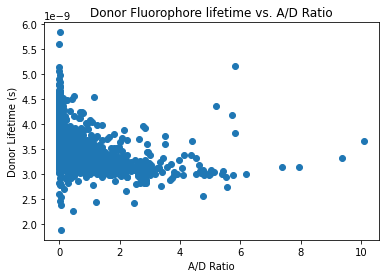

In [4]:
# Run this cell to plot raw data

# change the entries below to df["title of desired column"] to change plot values
x_data = df["Acceptor_intensity"] / df["Donor_intensity"]
y_data = df["Donor_lifetime"]

# change the entries below to edit plot labels/title
title = 'Donor Fluorophore lifetime vs. A/D Ratio'
x_label = 'A/D Ratio'
y_label = 'Donor Lifetime (s)'


plt.figure()
plt.plot(x_data, y_data, 'o')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()

# Data Filtering
Raw data usually needs to be filtered before it can be used productively. 

Filter parameters to consider may include: 
- ROI size
- donor lifetime
- mean donor intensity
- acceptor to donor ratio
- FRET efficiency
- etc

Filter operations exclusively include:
- \> (use "gt")
- \< (use "lt")
- \>= (use "ge")
- \<= (use "le")
- == (use "ee")

N.B. The filtered dataframe is called subdf as opposed to df.

In [5]:
# Run this cell to save filter parameters 
# replace None below with the desired filter parameter
#   ex: to select only ROIs with more than 10 pixels -> replace None after 'ROI_size' with "gt10" 
#   N.B. filter parameters must be surrounded by either single or double quotation marks and all operators must be written using provided abbreviations.

ISS_filter_params = {
    'ROI_size':None,
    'Donor_T0_intensity':None,
    'Acceptor_T0_intensity':None,
    'Donor_intensity':None,
    'Acceptor_intensity':None,
    'Acceptor/Donor_ratio':None,
    'Donor_lifetime':None,
    'Phasor_G':None,
    'Phasor_S':None,
    'FRET_efficiency':None
}

INO_filter_params = {
    'Well_ID':None,    #Well_ID only supports == ("ee") operations
    'ROI_size':None,
    'T0_intensity':None,
    'Donor_intensity':None,
    'Spectral_Range0_intensity':None,    
    'Spectral_Range1_intensity':None,
    'Spectral_Range2_intensity':None,
    'Spectral_Range3_intensity':None,
    'Acceptor/Donor_ratio':None,
    'Donor_lifetime':None,
    'Phasor_G':None,
    'Phasor_S':None,
    'FRET_efficiency':None
}

In [6]:
# Run this cell to apply saved filter parameters above to the dataframe.

subdf = filter_df(df, **ISS_filter_params)  #change **ISS_filter_parameters to **INO_filter_parameters if working with data from an INO image.

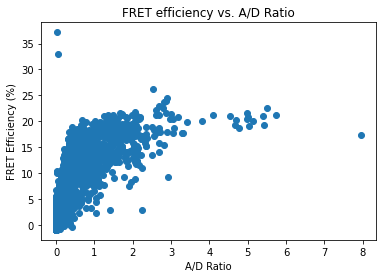

In [7]:
# Run this cell to plot filtered data

# change the entries below to subdf["title of desired column"] to change plot data
x_data = subdf["Acceptor_intensity"] / subdf["Donor_intensity"]
y_data = subdf["FRET_efficiency"]

# change the entries below to edit plot labels/title
title = 'FRET efficiency vs. A/D Ratio'
xlabel = 'A/D Ratio'
ylabel = 'FRET Efficiency (%)'

plt.figure()
plt.plot(x_data, y_data, 'o')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.show()

# Binning

Bin the filtered data and calculate mean, median, standard deviation, and standard error.

Bins can be automatically or manually generated.

In [8]:
# Run this cell to save custom bin edges

# Fill the list below with desired bin edges
#    :ex x_axis_bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]  will produce 5 bins of width 1, centered at 0, 1, 2, 3, 4

x_axis_bins = [ ]

In [9]:
# Run this cell to bin selected data

# Change the entries below to set what gets binned.
x_data = subdf["Acceptor_intensity"] / subdf["Donor_intensity"]
y_data = subdf["FRET_efficiency"]
auto_bins = True                      # if True: bins will be set automatically.
custom_bins = x_axis_bins             # auto_bins must be set to False to use custom bins

#change the value of csv_name to save binned data to the desired location
csv_name = r'ROI_binned_data.csv'


bin_size, y_means, y_medians, y_std_devs, y_std_errs, x_bin_centers, x_means = data_binning(x_data, y_data, auto_bins=auto_bins, bin_edges=custom_bins)

bindf = pd.DataFrame({
    'bin_size':bin_size,
    'y_means':y_means,
    'y_medians':y_medians,
    'y_std_devs':y_std_devs,
    'y_std_errs':y_std_errs,
    'x_bin_centers':x_bin_centers,
    'x_means':x_means
})
bindf.to_csv(csv_name)
bindf

,bin_size,y_means,y_medians,y_std_devs,y_std_errs,x_bin_centers,x_means
0,10144,1.795409,1.776877,1.308597,0.012993,0.000000,0.012674
1,547,7.905883,8.464446,4.220938,0.180474,0.238326,0.230572
2,319,12.592326,13.394283,3.791939,0.212308,0.476652,0.463452
3,287,13.920446,14.569142,3.250660,0.191880,0.714978,0.704479
4,173,13.163346,13.342303,3.284851,0.249743,0.953304,0.930283
5,93,14.682686,14.474786,3.375710,0.350045,1.191630,1.189436
6,79,15.765712,16.384643,3.229348,0.363330,1.429956,1.420950
7,44,16.575385,17.102843,2.741639,0.413318,1.668282,1.656421
8,45,16.436741,17.363409,3.122293,0.465444,1.906608,1.913675
9,106,16.208311,16.868316,3.444371,0.334547,2.144934,2.045806


# Curve Fitting

Curve fitting can be applied to binned data.

The default curve to be fitted is:

$$E\% =\frac{[Emax * (I_{acceptor}/I_{donor})^h}{Kd^h + (I_{acceptor}/I_{donor})^h} $$

since $I_{acceptor}/I_{donor}$ is just the acceptor to donor ratio, the equation is:

$$E\% =\frac{[Emax * (A:D)^h}{Kd^h + (A:D)^h} $$

In [10]:
# Run this cell to calculate curve parameters

#this line removes bins with only 1 or fewer values
bindf = bindf[bindf['bin_size'] > 1]

# Change the entries below to set data for curve fit
x_vals = bindf['x_means']
y_vals = bindf['y_means']
y_errs = bindf['y_std_devs']


def model_function(ratio, Emax, Kd, h):
    return (Emax * ratio**h)/(Kd**h + ratio**h)

popt, pcov = opt.curve_fit(model_function, x_vals, y_vals, sigma=y_errs, maxfev=200000)

print('Emax:', popt[0])
print('Kd:', popt[1])
print('h:', popt[2])

Emax: 27.216201124048197
Kd: 0.7851258122999883
h: 0.6513993436661363


<ipython-input-10-6213cf92a4cd>:13: RuntimeWarning: invalid value encountered in double_scalars
  return (Emax * ratio**h)/(Kd**h + ratio**h)


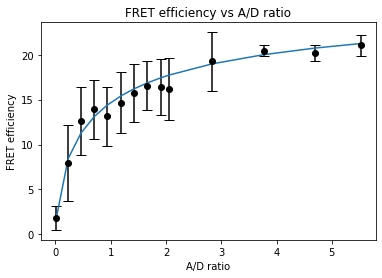

In [11]:
# Run this cell to plot bins and curve fit

# Change entries below below to change plot data
x_vals = bindf['x_means']
y_vals = bindf['y_means']
y_errs = bindf['y_std_devs']

# Change the entries below to edit plot labels/titles
x_label = 'A/D ratio'
y_label = 'FRET efficiency'
title = 'FRET efficiency vs A/D ratio'


plt.figure()
plt.errorbar(x_vals, y_vals, yerr=y_errs, fmt='ko', capsize=5, capthick=1)
plt.plot(x_vals, model_function(x_vals, popt[0], popt[1], popt[2]))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()